In [8]:
import os
import scipy
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator
from keras.layers import Dense, Dropout, Flatten, Normalization, Conv1D, MaxPool1D, LSTM
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import tensorflow as tf



In [9]:
# our usual useful functions

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print(f"Saved model to {filename_base}.json and weights to {filename_base}.h5")

In [10]:
x_d = np.load('xtrain.npy')
y_num = np.load('ytrain_num.npy')
y_gender = np.load('ytrain_gender.npy')
x_s = np.load('x_spectrum_train.npy')


In [11]:
def spectrum_data(audio_tracks):
    X = np.empty((25000,128, 128))
    for i, audio_track in enumerate(tqdm(audio_tracks)):        
        f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
        Zxx_ = np.abs(Zxx[0:227, 2:-1])
        Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
        Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)
        Zxx_ = resize(Zxx_, (1, 128, 128))
        X[i] = Zxx_
    return X



100%|██████████| 25000/25000 [02:35<00:00, 160.37it/s]


In [38]:
def prepare_data(X,Y):
    X_train, X_validation, Y_train, Y_validation = sklearn.model_selection.train_test_split(X, Y, test_size=.1)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_train = one_hot_encoder.fit_transform(Y_train.reshape(-1, 1))
    Y_validation = one_hot_encoder.fit_transform(Y_validation.reshape(-1, 1))
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
    X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1, 1)
    return X_train, X_validation, Y_train, Y_validation

#X_train, X_validation, Y_train, Y_validation = prepare_data(x_d, y_gender)
X_train_spectrum, X_validation_spectrum, Y_train, Y_validation = prepare_data(x_s, y_num)



In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
c_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

**Exercise 1A**

In [ ]:
inputs = keras.layers.Input(shape=(8000,1))
x = inputs

x = Conv1D(16, 3, activation='relu', strides=(1))(x)
x = Conv1D(16, 3, activation='relu', strides=(1))(x)
x = Conv1D(16, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='second_layer')(x)
x = Dropout(0.25)(x)

x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(2, name='end_layer')(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dropout(0.25)(x)
x = Dense(6, activation='relu')(x)

predictions = Dense(2, activation='sigmoid')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
model.summary()

**Exercise 1B**

In [ ]:
inputs = keras.layers.Input(shape=(8000,1))
x = inputs  # Don't flatten until after your 2D layers
print(x.shape)
x = Conv1D(64, 3, activation='relu', strides=(1))(x)
x = Conv1D(64, 3, activation='relu', strides=(1))(x)
x = Conv1D(64, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='first_layer')(x)
  #x = Dropout(0.25)(x)
x = Dropout(0.25)(x)


x = Conv1D(32, 3, activation='relu', strides=(1))(x)
x = Conv1D(32, 3, activation='relu', strides=(1))(x)
x = Conv1D(32, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='second_layer')(x)
x = Dropout(0.25)(x)


x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='end_layer')(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
print(x.shape)
#x = Dense(512, activation='relu')(x)
x = Dense(24, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dropout(0.3)(x)
#x = Dense(128, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(16, activation='relu')(x)


predictions = Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model.summary()

** LSTM **

In [ ]:
print(X_train_spectrum.shape)
inputs = keras.layers.Input(shape=(8000,1,1))
x = inputs

x = LSTM(16, return_sequences=True)(inputs)
x = LSTM(8)(x)

x = Flatten()(x)

#x = Dropout(0.25)(x)
#x = Dense(16, activation='relu')(x)
#x = Dense(8, activation='relu')(x)
#x = Dense(4, activation='relu')(x)


predictions = Dense(2, activation='sigmoid')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
model.summary()

** Exercise 2A **

In [ ]:
inputs = keras.layers.Input(shape=(128,128,1))
x = inputs

x = Conv1D(16, 3, activation='relu', strides=(1))(x)
x = Conv1D(16, 3, activation='relu', strides=(1))(x)
x = Conv1D(16, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='second_layer')(x)
x = Dropout(0.25)(x)

x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(2, name='end_layer')(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dropout(0.225)(x)
x = Dense(8, activation='relu')(x)
#x = Dropout(0.25)(x)
#x = Dense(4, activation='sigmoid')(x)

predictions = Dense(2, activation='sigmoid')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
model.summary()

** Aufgabe 2B **

In [39]:
inputs = keras.layers.Input(shape=(128,128,1))
x = inputs  # Don't flatten until after your 2D layers
x = Conv1D(64, 3, activation='relu', strides=(1))(x)
x = Conv1D(64, 3, activation='relu', strides=(1))(x)
x = Conv1D(64, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='first_layer')(x)
  #x = Dropout(0.25)(x)
x = Dropout(0.25)(x)


x = Conv1D(32, 3, activation='relu', strides=(1))(x)
x = Conv1D(32, 3, activation='relu', strides=(1))(x)
x = Conv1D(32, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='second_layer')(x)
x = Dropout(0.25)(x)


x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='end_layer')(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
#x = Dense(512, activation='relu')(x)
x = Dense(24, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dropout(0.3)(x)
#x = Dense(128, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(16, activation='relu')(x)


predictions = Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model.summary()

(None, 8000, 1)
(None, 984)
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 8000, 1)]         0         
                                                                 
 conv1d_78 (Conv1D)          (None, 7998, 64)          256       
                                                                 
 conv1d_79 (Conv1D)          (None, 7996, 64)          12352     
                                                                 
 conv1d_80 (Conv1D)          (None, 7994, 64)          12352     
                                                                 
 first_layer (MaxPooling1D)  (None, 1998, 64)          0         
                                                                 
 dropout_39 (Dropout)        (None, 1998, 64)          0         
                                                                 
 conv1d_81 (Conv1D)          (

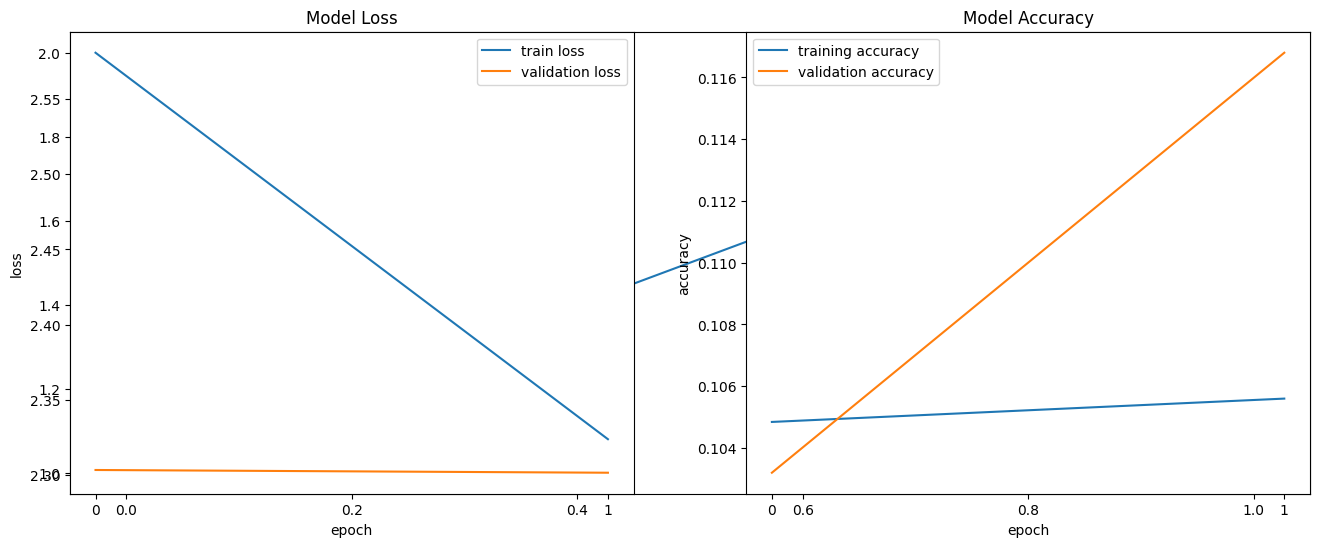

88/88 [==============================] - 23s 256ms/step - loss: 2.3240 - accuracy: 0.1056 - val_loss: 2.3017 - val_accuracy: 0.1168 - lr: 1.0000e-04
Epoch 3/300
69/88 [======================>.......] - ETA: 4s - loss: 2.3112 - accuracy: 0.1051

In [ ]:
num_epochs = 300
pltCallBack = PlotLossAccuracy()
model.fit(X_train_spectrum, Y_train,
        batch_size=256, epochs=num_epochs,
        validation_data=(X_validation_spectrum, Y_validation),
        callbacks=[pltCallBack, c_schedule])


In [ ]:
model_1A =  # Figure this out
save_model_to_disk(model_1A, 'waveform_gender_model')

In [ ]:
model_1B = # Figure this out
save_model_to_disk(model_1B, 'waveform_digit_model')

In [ ]:
model_2A = model # Figure this out
save_model_to_disk(model_2A, 'spectrogram_gender_model')

In [ ]:
model_2B = # Figure this out
save_model_to_disk(model_2B, 'spectrogram_digit_model')